In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as tdata

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [3]:
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transform),
        batch_size=batch_size, shuffle=True)
    
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transform),
        batch_size=batch_size, shuffle=True)

In [ ]:
from torch_utils.training import train_step, test_step
from tqdm import tqdm_notebook

model = Net()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for i in tqdm_notebook(range(100)):
    train_step(model, train_loader, optimizer,
               epoch=i, log_interval=1000)
    test_step(model, test_loader)

HBox(children=(IntProgress(value=0), HTML(value='')))

Train Epoch: 0                    [(0, 0)/60000                    (0.0%)]	Loss: 2.299952745437622
Train Epoch: 0                    [(0, 32000)/60000                    (53.333333333333336%)]	Loss: 0.27403131127357483

Test set: Average loss: 0.09924335248172284,           Accuracy: 9714/10000           (97.14%)

Train Epoch: 1                    [(1, 0)/60000                    (0.0%)]	Loss: 0.16573360562324524
Train Epoch: 1                    [(1, 32000)/60000                    (53.333333333333336%)]	Loss: 0.08379770070314407

Test set: Average loss: 0.07329431952498854,           Accuracy: 9782/10000           (97.82%)

Train Epoch: 2                    [(2, 0)/60000                    (0.0%)]	Loss: 0.061557549983263016
Train Epoch: 2                    [(2, 32000)/60000                    (53.333333333333336%)]	Loss: 0.20928236842155457

Test set: Average loss: 0.0620647753406316,           Accuracy: 9812/10000           (98.12%)

Train Epoch: 3                    [(3, 0)/60000 


Test set: Average loss: 0.03526495481065358,           Accuracy: 9903/10000           (99.03%)

Train Epoch: 26                    [(26, 0)/60000                    (0.0%)]	Loss: 0.12059880048036575
Train Epoch: 26                    [(26, 32000)/60000                    (53.333333333333336%)]	Loss: 0.11022636294364929

Test set: Average loss: 0.03339393298791256,           Accuracy: 9903/10000           (99.03%)

Train Epoch: 27                    [(27, 0)/60000                    (0.0%)]	Loss: 0.027095505967736244


In [69]:
from torch.autograd import Variable

def get_gradient_wrt_output(model, inputs, output_idx=0, device='cpu'):
    model.eval()
    n_batch = inputs.size(0)
    if np.issubdtype(type(output_idx), np.integer):
        output_idx = [output_idx for _ in range(n_batch)]
    output_list = []
    grad_list = []
    for i in range(n_batch):
        model.zero_grad()
        input_var = Variable(inputs[[i]], requires_grad=True)
        output = model(input_var)[0][output_idx[i]]
        output.backward()
        output_list.append(output)
        grad_list.append(input_var.grad[0])
    grads = torch.stack(grad_list).detach().numpy()
    outputs = torch.stack(output_list).detach().numpy()
    return grads, outputs

In [70]:
for i, (data, target) in enumerate(train_loader):
    if i > 0:
        break

In [71]:
gradient, output = get_gradient_wrt_output(model, data, output_idx=0)

In [72]:
output.shape

(32,)

In [73]:
gradient.shape

(32, 1, 28, 28)

In [74]:
data.shape

torch.Size([32, 1, 28, 28])

In [241]:
import numpy as np

def integrated_gradients(model, input, output_idx=None, baseline=None, steps=50):
    if baseline is None:
        baseline = 0. * input
    assert(baseline.shape == input.shape)
    if output_idx is None:
        input_ = torch.stack([input])
        output = model(input_)
        output_idx = output.max(1)[1][0]
    # Scale input and compute gradients.
    scaled_inputs = [baseline + (float(i) / steps) * (input - baseline) for i in range(0, steps+1)]
    scaled_inputs = torch.stack(scaled_inputs)
    grads, outputs = get_gradient_wrt_output(model, scaled_inputs)
    mean_grads = np.mean(grads, axis=0)
    integrated_gradients = (input.numpy() - baseline.numpy()) * mean_grads
    output = outputs[-1]
    return integrated_gradients, output

In [242]:
grads, output = integrated_gradients(model, data[0])

In [243]:
grads.shape

(1, 28, 28)

In [255]:
test_data = {}
for X, y in test_loader:
    output = model(X)
    pred_val, pred_idx = output.max(1)
    flag = torch.eq(pred_idx, y)
    y = y[flag]
    pred_val = pred_val[flag]
    X = X[flag]
    for conf, X_i, y_i in zip(pred_val, X, y):
        val = test_data.get(y_i.item(), None)
        if val is None:
            test_data[y_i.item()] = (conf.item(), X_i)
        else:
            if conf.item() > val[0]:
                test_data[y_i.item()] = (conf.item(), X_i)


In [256]:
results = dict()
for idx, test_item in test_data.items():
    X = test_item[1]
    grads, output = integrated_gradients(model, X)
    results[idx] = (X[0].numpy(), grads[0])

In [257]:
results = dict()
for idx, test_item in test_data.items():
    X = test_item[1]
    grads, output = integrated_gradients(model, X)
    results[idx] = (X[0].numpy(), grads[0])

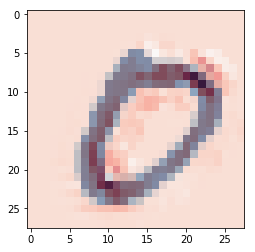

In [258]:
import matplotlib.pyplot as plt
%matplotlib inline

idx = 0
plt.imshow(results[idx][0], cmap='Blues')
plt.imshow(results[idx][1], cmap='Reds', alpha=.5)

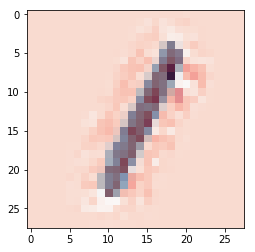

In [259]:
idx = 1
plt.imshow(results[idx][0], cmap='Blues')
plt.imshow(-results[idx][1], cmap='Reds', alpha=.5)

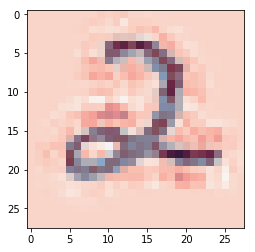

In [260]:
idx = 2
plt.imshow(results[idx][0], cmap='Blues')
plt.imshow(-results[idx][1], cmap='Reds', alpha=.5)

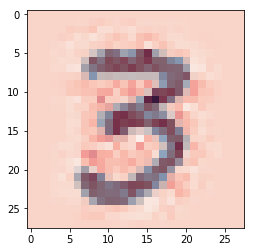

In [261]:
idx = 3
plt.imshow(results[idx][0], cmap='Blues')
plt.imshow(-results[idx][1], cmap='Reds', alpha=.5)

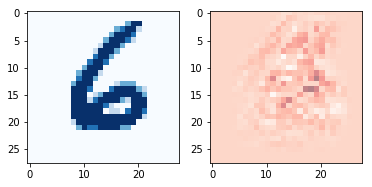

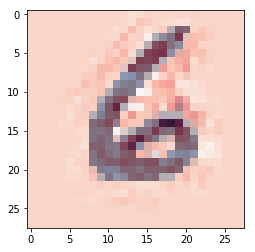

In [276]:
idx = 6
fig, ax = plt.subplots(1, 2)
ax[0].imshow(results[idx][0], cmap='Blues')
ax[1].imshow(-results[idx][1], cmap='Reds', alpha=.5)
plt.figure()
plt.imshow(results[idx][0], cmap='Blues')
plt.imshow(-results[idx][1], cmap='Reds', alpha=.5)

In [267]:
help(plt.subplots)

Help on function subplots in module matplotlib.pyplot:

subplots(nrows=1, ncols=1, sharex=False, sharey=False, squeeze=True, subplot_kw=None, gridspec_kw=None, **fig_kw)
    Create a figure and a set of subplots
    
    This utility wrapper makes it convenient to create common layouts of
    subplots, including the enclosing figure object, in a single call.
    
    Parameters
    ----------
    nrows, ncols : int, optional, default: 1
        Number of rows/columns of the subplot grid.
    
    sharex, sharey : bool or {'none', 'all', 'row', 'col'}, default: False
        Controls sharing of properties among x (`sharex`) or y (`sharey`)
        axes:
    
            - True or 'all': x- or y-axis will be shared among all
              subplots.
            - False or 'none': each subplot x- or y-axis will be
              independent.
            - 'row': each subplot row will share an x- or y-axis.
            - 'col': each subplot column will share an x- or y-axis.
    
        Whe

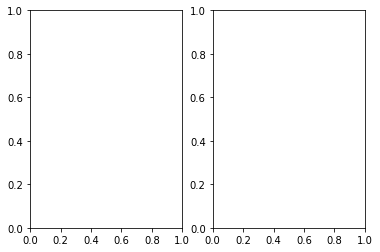

In [269]:
fig, ax = plt.subplots(1, 2)

In [271]:
ax[0]